In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('../'))
from utils.osm_helper import node2pt, way2line, rltn2poly, osm_container

# read origin OSM

In [2]:
DCOSM_DATA_PATH = '../data/washingtonDC.osm'
OUTPUT_DIR = '../data/output/'

In [4]:
OSM_DATA = osm_container(DCOSM_DATA_PATH)
print OSM_DATA.data_size()

begin reading osm 2016-11-09 21:20:22.733000
finish reading osm 2016-11-09 21:21:34.637000
["len of <class 'osmread.elements.Way'> = 306332", "len of <class 'osmread.elements.Relation'> = 3427", "len of <class 'osmread.elements.Node'> = 2546260"]


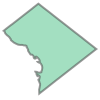

In [5]:
import geopandas as gp
%matplotlib inline
dc_boundary_gpdf = gp.read_file('../data/dc_polygon.geojson')
dc_boundary = dc_boundary_gpdf.geometry.values[0]
dc_boundary

In [6]:
from osmread import parse_file, Node, Way, Relation
import datetime
import shapely.geometry as shpgeo

In [7]:
def get_dc_nodes(nodes, dc_boundary):
    print datetime.datetime.now()
    dc_nodes = []
    for node in nodes:
        pt = node2pt(node)
        if pt.intersects(dc_boundary):
            dc_nodes.append(node)
    print datetime.datetime.now()
    return dc_nodes

def get_dc_ways(ways, dc_boundary):
    print datetime.datetime.now()
    dc_ways = []
    way_with_one_node = []
    for way in ways:
        if way.nodes.__len__()>1:
            ln = way2line(OSM_DATA, way)
            if ln.intersects(dc_boundary):
                dc_ways.append(way)
        else:
            way_with_one_node.append(way)
    print datetime.datetime.now()
    return dc_ways

In [8]:
DC_NODES = get_dc_nodes(OSM_DATA.osm_objs[Node], dc_boundary)
DC_WAYS = get_dc_ways(OSM_DATA.osm_objs[Way], dc_boundary)

2016-11-09 21:21:39.828000
2016-11-09 21:26:10.820000
2016-11-09 21:26:10.820000
2016-11-09 21:27:11.974000


# Out put OSM within DC polygon

In [96]:
s.decode('unicode_escape')

ImportError: No module named BeautifulSoup

In [110]:

s = cgi.escape( 'http://siris-artinventories.si.edu/ipac20/ipac.jsp?&profile=all&source=~!siartinventories&uri=full=3100001~!6508~!0#focus')   # s = "&amp; &lt; &gt;"
s

'http://siris-artinventories.si.edu/ipac20/ipac.jsp?&amp;profile=all&amp;source=~!siartinventories&amp;uri=full=3100001~!6508~!0#focus'

In [101]:
for n in DC_NODES:
    if n.id==358960371:
        print n
        break

Node(id=358960371L, version=3, changeset=33846823, timestamp=1441601622, uid=307520, tags={u'gnis:state_id': u'11', u'name': u'Louis Daguerre Statue', u'wikipedia': u'en:Daguerre Memorial', u'gnis:county_id': u'001', u'artist_name': u'Jonathan Scott Hartley', u'ele': u'15', u'note': u'More about this sculpture: http://siris-artinventories.si.edu/ipac20/ipac.jsp?&profile=all&source=~!siartinventories&uri=full=3100001~!6508~!0#focus', u'gnis:created': u'09/26/2003', u'gnis:feature_id': u'2002612', u'artwork_type': u'statue', u'tourism': u'artwork'}, lon=-77.0221987, lat=38.897334)


In [104]:
unicode('http://siris-artinventories.si.edu/ipac20/ipac.jsp?&profile=all&source=~!siartinventories&uri=full=3100001~!6508~!0#focus').decode('string_escape')

'http://siris-artinventories.si.edu/ipac20/ipac.jsp?&profile=all&source=~!siartinventories&uri=full=3100001~!6508~!0#focus'

In [98]:
unicode("More about this sculpture: http://siris-artinventories.si.edu/ipac20/ipac.jsp?&amp;profile=all&amp;source=~!siartinventories&amp;uri=full=3100001~!6508~!0#focus").encode('utf-8')

'More about this sculpture: http://siris-artinventories.si.edu/ipac20/ipac.jsp?&amp;profile=all&amp;source=~!siartinventories&amp;uri=full=3100001~!6508~!0#focus'

In [116]:
def fromts(ts):
    time_type = datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=ts)
    return datetime.datetime.strftime(time_type, '%Y-%m-%dT%H:%M:%SZ')

def get_key_str(osm_obj, keys):
    import cgi
    obj_str = ''
    for k in keys:
        if hasattr(osm_obj,k):
            s = getattr(osm_obj, k) if not k=='timestamp' else fromts(getattr(osm_obj, k))
            obj_str += cgi.escape(' {}="{}"'.format(k, s))
        else:
            print k, osm_obj
    return obj_str

def get_tag_str(osm_obj):
    tag_str = ''
    for k, v in osm_obj.tags.items():
        tag_str += '\n <tag k="{}" v="{}"/>'.format(cgi.escape(k.encode('utf-8')),cgi.escape(v.encode('utf-8')))
    return tag_str

def get_node_str(osm_node):
    keys = ['id', 'version', 'changeset','timestamp', 'uid', 'lat', 'lon']
    node_str = 'node'
    node_str += get_key_str(osm_node, keys)
    if osm_node.tags:
        node_str = '<{}>'.format(node_str)
        node_str += get_tag_str(osm_node)
        node_str += '\n </node>'
    else:
        node_str = ' <{}/>'.format(node_str)
    return node_str

def get_nodes_in_way_str(osm_way):
    nstr = ['\n  <nd ref="{}"/>'.format(nid) for nid in osm_way.nodes]
    return ''.join(nstr)
    
def get_way_str(osm_way):
    keys = ['id', 'version', 'changeset', 'timestamp', 'uid']
    assert len(osm_way.nodes)!=0
    way_str = 'way'
    way_str += get_key_str(osm_way, keys)
    way_str = '<{}>'.format(way_str)
    way_str += get_nodes_in_way_str(osm_way)
    if osm_way.tags:
        way_str += get_tag_str(osm_way)
    way_str += '\n </way>'
    return way_str
    
def output_osm(osm_objs, file_path):
    file_str = ['<?xml version="1.0" encoding="UTF-8"?>']
    file_str.append('<osm version="0.6" generator="CGImap 0.5.4 (14394 thorn-01.openstreetmap.org)" copyright="OpenStreetMap and contributors" attribution="http://www.openstreetmap.org/copyright" license="http://opendatacommons.org/licenses/odbl/1-0/">')
    for otype, objs in osm_objs.items():
        get_str = {'Way': get_way_str, 'Node': get_node_str}[otype]
        for obj in objs:
            obj_str = get_str(obj)
            file_str.append(obj_str)
    file_str.append('</osm>')
    with open(file_path, 'w') as f:
        for s in file_str:
            f.write(s+'\n')
        


In [117]:
DC_OBJS = {
    'Node': DC_NODES,
    'Way': DC_WAYS,
}
output_osm(DC_OBJS,'../data/OSMinDCPoly.osm')